# Senior Income and Home Value Distributions For San Diego County

This package extracts the home value and household income for households in San DIego county with one or more household members aged 65 or older. .  The base data is from the 2015 5 year PUMS sample, from IPUMS<sup>[1](#ipums)</sup>. The dataset variables used are: HHINCOME and VALUEH. 


This extract is intended for analysis of senior issues in San Diego County, so the record used are further restricted with these filters: 

* WHERE AGE > = 65
* HHINCOME < 9999999
* VALUEH < 9999999 
* STATEFIP = 6 
* COUNTYFIPS = 73

The limits on the HHINCOME and VALUEH variables eliminate top coding. 

This analysis used the IPUMS [(ipums)](#ipums) data


In [1]:
%matplotlib inline
%load_ext metatab

%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import metatab as mt
import seaborn as sns; sns.set(color_codes=True)
import sqlite3

import statsmodels as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy import integrate, stats

from sdipylib.incomedist import * 
from sdipylib.multikde import MultiKde 


plt.rcParams['figure.figsize']=(6,6)

In [2]:
%%metatab 
Origin: ipums.org
Dataset: income_homevalue
Identifier: b407e5af-cc23-431d-a431-15c202ec0c3b
Version: 3

Section: Contacts
Wrangler: Eric Busboom
Wrangler.Email: eric@civicknowledge.com
    
Section: Bibliography
Citation: ipums
Citation.Type: dataset
Citation.Author: Steven Ruggles; Katie Genadek; Ronald Goeken; Josiah Grover; Matthew Sobek
Citation.Title: Integrated Public Use Microdata Series
Citation.Year: 2017
Citation.Publisher: University of Minnesota
Citation.Version: 7.0 
Citation.AccessDate: 20170718
Citation.Url: https://usa.ipums.org/usa/index.shtml
Citation.Doi: https://doi.org/10.18128/D010.V7.0
        
Citation: bordley
Citation.Type: article
Citation.Author: Robert F. Bordley; James B. McDonald; Anand Mantrala
Citation.Title: Something New, Something Old: Parametric Models for the Size of Distribution of Income
Citation.Year: 1997
Citation.Month: June
Citation.Journal: Journal of Income Distribution
Citation.Volume: 6 
Citation.Number: 1
Citation.Pages: 5-5
Citation.Url: https://ideas.repec.org/a/jid/journl/y1997v06i1p5-5.html
        
Citation: mcdonald
Citation.Type: article 
Citation.Author: McDonald, James B.;  Mantrala, Anand
Citation.Title: The distribution of personal income: Revisited
Citation.Journal: Journal of Applied Econometrics
Citation.Volume: 10
Citation.Number: 2
Citation.Publisher: Wiley Subscription Services, Inc., A Wiley Company
Citation.Issn: 1099-1255
Citation.Doi: 10.1002/jae.3950100208
Citation.Pages: 201--204,
Citation.Year: 1995
    
Citation: majumder
Citation.Type: article 
Citation.Author: Majumder, Amita; Chakravarty, Satya Ranjan
Citation.Title: Distribution of personal income: Development of a new model and its application to U.S. income data
Citation.Journal: Journal of Applied Econometrics
Citation.Volume: 5
Citation.Number: 2
Citation.Publisher: Wiley Subscription Services, Inc., A Wiley Company
Citation.Issn: 1099-1255
Citation.Doi: 10.1002/jae.3950050206
Citation.Pages: 189--196
Citation.Year: 1990

In [3]:
%%bash
# Create a sample of a SQL database, so we can edit the schema. 
# Run the cell once to create the schema, then edit the schema and run it 
# again to build the database. 

fn='/Volumes/Storage/Downloads/usa_00004.csv'
if [ ! -e schema.sql ]
then
    head -100 $fn > sample.csv
    sqlite3 --csv ipums.sqlite '.import sample.csv ipums'
    sqlite3 ipums.sqlite  .schema > schema.sql
    sqlite3 -header ipums.sqlite "select * from ipums limit 2"  > sample.sql # Show a sample of data
    rm ipums.sqlite
fi    

if [ -e schema.sql -a \( ! -e ipums.sqlite \) ]
then
    sqlite3 ipums.sqlite < schema.sql
    sqlite3 --csv ipums.sqlite ".import $fn ipums"
    # Create some indexes to speed up queries
    sqlite3 ipums.sqlite "CREATE INDEX IF NOT EXISTS state_idx ON ipums (STATEFIP)"
    sqlite3 ipums.sqlite "CREATE INDEX IF NOT EXISTS county_idx ON ipums (COUNTYFIPS)"
    sqlite3 ipums.sqlite "CREATE INDEX IF NOT EXISTS state_county_idx ON ipums (STATEFIP, COUNTYFIPS)"
    
fi

# Source Data

The PUMS data is a sample, so both household and person records have weights. We use those weights to replicate records. We are not adjusting the values for CPI, since we don't have a CPI for 2015, and because the medians for income comes out pretty close to those from the 2015 5Y ACS. 

The `HHINCOME` and `VALUEH` have the typical distributions for income and home values, both of which look like Poisson distributions. 


In [4]:
# Check the weights for the whole file to see if they sum to the number
# of households and people in the county. They don't, but the sum of the weights for households is close, 
# 126,279,060 vs about 116M housholds
con = sqlite3.connect("ipums.sqlite")
wt = pd.read_sql_query("SELECT YEAR, DATANUM, SERIAL, HHWT, PERNUM, PERWT FROM ipums "
                       "WHERE PERNUM = 1 AND YEAR = 2015", con)

wt.drop(0, inplace=True)

nd_s = wt.drop_duplicates(['YEAR', 'DATANUM','SERIAL'])
country_hhwt_sum = nd_s[nd_s.PERNUM == 1]['HHWT'].sum()

len(wt), len(nd_s), country_hhwt_sum

(1375480, 1375480, 126279060)

In [5]:
import sqlite3

# PERNUM = 1 ensures only record for each household 

con = sqlite3.connect("ipums.sqlite")
senior_hh = pd.read_sql_query(
                       "SELECT DISTINCT SERIAL, HHWT, PERWT, HHINCOME, VALUEH "
                       "FROM ipums "
                       "WHERE AGE >= 65 " 
                       "AND HHINCOME < 9999999 AND VALUEH < 9999999 "
                       "AND STATEFIP = 6 AND COUNTYFIPS=73 ", con)

In [6]:
# Since we're doing a probabilistic simulation, the easiest way to deal with the weight is just to repeat rows. 
# However, adding the weights doesn't change the statistics much, so they are turned off now, for speed. 

def generate_data():
    
    for index, row in senior_hh.drop_duplicates('SERIAL').iterrows():
        #for i in range(row.HHWT):
        yield (row.HHINCOME, row.VALUEH)
  
incv = pd.DataFrame(list(generate_data()), columns=['HHINCOME', 'VALUEH'])

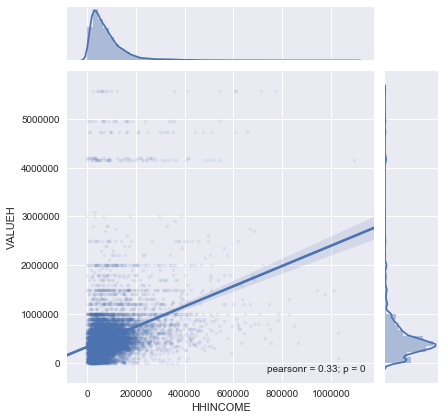

In [7]:

sns.jointplot(x="HHINCOME", y="VALUEH", marker='.', scatter_kws={'alpha': 0.1}, data=incv, kind='reg');

# Procedure

After extracting the data for HHINCOME and VALUEH, we rank both values and then quantize the rankings into 10 groups, 0 through 9, `hhincome_group` and `valueh_group`. The `HHINCOME` variable correlates with `VALUEH` at .36, and the quantized rankings `hhincome_group` and `valueh_group` correlate at .38.

Initial attempts were made to fit curves to the income and home value distributions, but it is very difficult to find well defined models that fit real income distributions. Bordley [(bordley)](#bordley) analyzes the fit for 15 different distributions, reporting success with variations of the generalized beta distribution, gamma and Weibull. Majumder [(majumder)](#majumder) proposes a four parameter model with variations for special cases. None of these models were considered well established enough to fit within the time contraints for the project, so this analysis will use empirical distributions that can be scale to fit alternate parameters. 


In [8]:

incv['valueh_rank'] = incv.rank()['VALUEH']
incv['valueh_group'] = pd.qcut(incv.valueh_rank, 10, labels=False )
incv['hhincome_rank'] = incv.rank()['HHINCOME']
incv['hhincome_group'] = pd.qcut(incv.hhincome_rank, 10, labels=False )
incv[['HHINCOME', 'VALUEH', 'hhincome_group', 'valueh_group']] .corr()

,HHINCOME,VALUEH,hhincome_group,valueh_group
HHINCOME,1.000000,0.328524,0.770237,0.352609
VALUEH,0.328524,1.000000,0.254894,0.660849
hhincome_group,0.770237,0.254894,1.000000,0.365379
valueh_group,0.352609,0.660849,0.365379,1.000000


In [9]:
from metatab.pands import MetatabDataFrame
odf = MetatabDataFrame(incv)
odf.name = 'income_homeval'
odf.title = 'Income and Home Value Records for San Diego County'
odf.HHINCOME.description = 'Household income'
odf.VALUEH.description = 'Home value'
odf.valueh_rank.description = 'Rank of the VALUEH value'
odf.valueh_group.description = 'The valueh_rank value quantized into 10 bins, from 0 to 9'
odf.hhincome_rank.description = 'Rank of the HHINCOME value'
odf.hhincome_group.description = 'The hhincome_rank value quantized into 10 bins, from 0 to 9'

%mt_add_dataframe odf  --materialize

Then, we group the dataset by `valueh_group` and collect all of the income values for each group. These groups have different distributions, with the lower numbered group shewing to the left and the higher numbered group skewing to the right. 

To use these groups in a simulation, the user would select a group for a subject's home value, then randomly select an income in that group. When this is done many times, the original `VALUEH` correlates to the new distribution ( here, as `t_income` ) at .33, reasonably similar to the original correlations. 

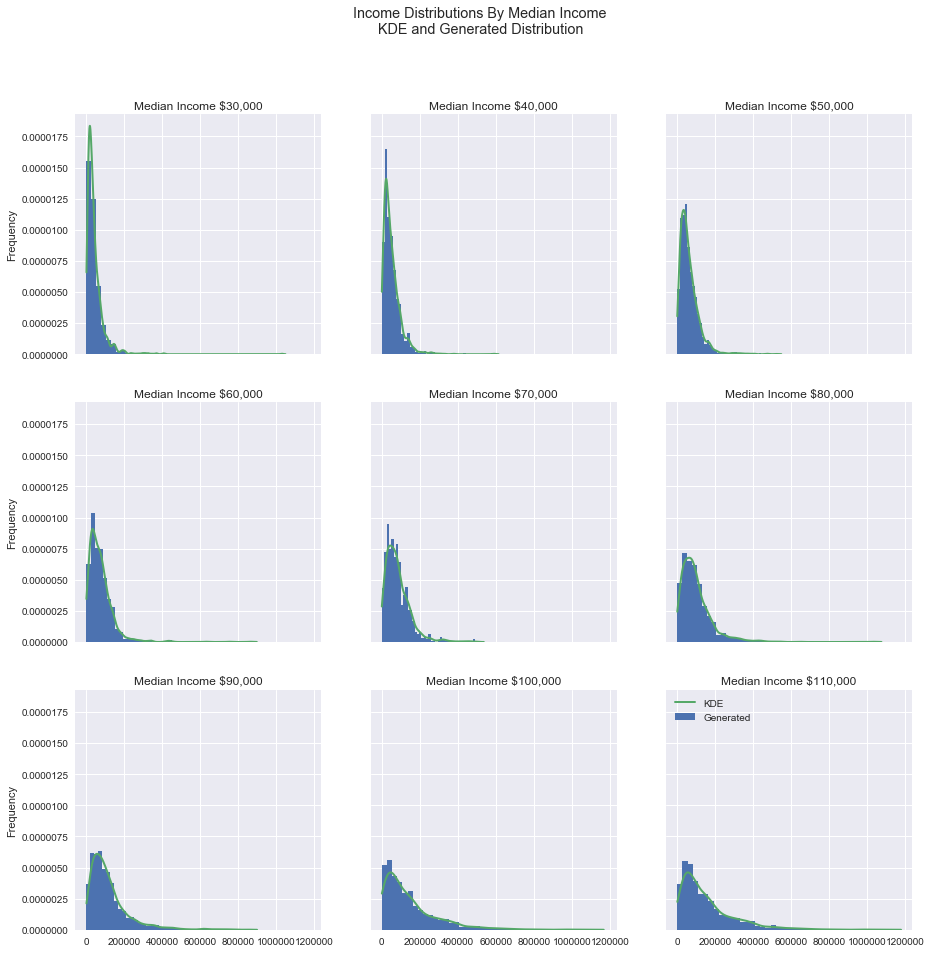

In [10]:
import matplotlib.pyplot as plt
import numpy as np

mk = MultiKde(odf, 'valueh_group', 'HHINCOME')

fig,AX = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,15))

incomes = [30000,
          40000,
          50000,
          60000,
          70000,
          80000,
          90000,
          100000,
          110000]

for mi, ax in zip(incomes, AX.flatten()):
    s, d, icdf, g = mk.make_kde(mi)
    syn_d = mk.syn_dist(mi, 10000)
   
    syn_d.plot.hist(ax=ax, bins=40, title='Median Income ${:0,.0f}'.format(mi), normed=True, label='Generated')

    ax.plot(s,d, lw=2, label='KDE')
    
fig.suptitle('Income Distributions By Median Income\nKDE and Generated Distribution')
plt.legend(loc='upper left')
plt.show()

A scatter matrix show similar structure for `VALUEH` and `t_income`.

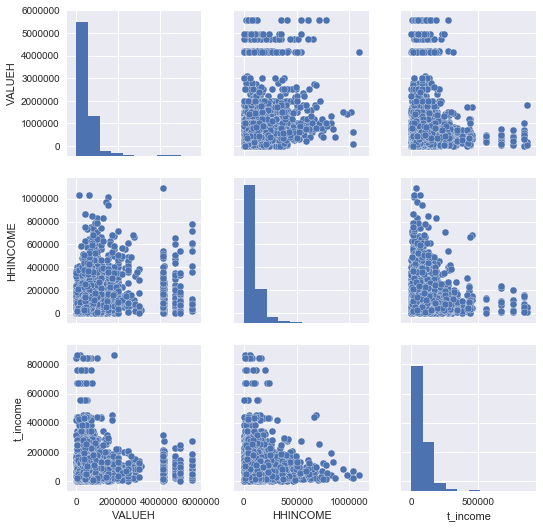

In [11]:
t = incv.copy()
t['t_income'] = mk.syn_dist(t.HHINCOME.median(), len(t))
t[['HHINCOME','VALUEH','t_income']].corr()

sns.pairplot(t[['VALUEH','HHINCOME','t_income']]);

The simulated incomes also have similar statistics to the original incomes. However, the median income is high. In San Diego county, the median household income for householders 65 and older in the 2015 5 year ACS about \$51K, versus \$56K here. For home values, the mean home value for 65+ old homeowners is \$468K in the 5 year ACS, vs \$510K here. 

In [12]:
from IPython.display import display_html, HTML
display(HTML("<h3>Descriptive Stats</h3>"))
t[['VALUEH','HHINCOME','t_income']].describe()

,VALUEH,HHINCOME,t_income
count,1.357900e+04,1.357900e+04,13579.000000
mean,5.026172e+05,8.569048e+04,75816.752351
std,5.430300e+05,8.603261e+04,65869.956657
min,1.300000e+02,0.000000e+00,57.728244
25%,2.500000e+05,3.300000e+04,34400.000000
50%,4.000000e+05,6.240000e+04,62400.000000
75%,6.000000e+05,1.076250e+05,98403.800916
max,5.567000e+06,1.095000e+06,863300.000000


In [13]:
display(HTML("<h3>Correlations</h3>"))
t[['VALUEH','HHINCOME','t_income']].corr()

,VALUEH,HHINCOME,t_income
VALUEH,1.000000,0.328524,0.011722
HHINCOME,0.328524,1.000000,0.007250
t_income,0.011722,0.007250,1.000000


# Bibliography

In [14]:
%mt_bibliography

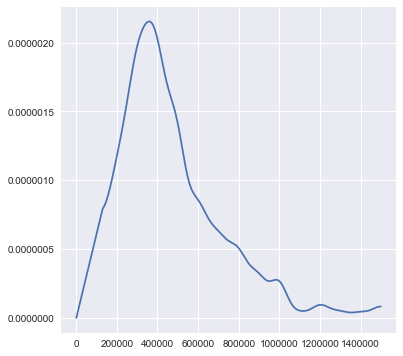

In [15]:
s,d = make_prototype(incv.VALUEH.astype(float), 130_000, 1_500_000)

plt.plot(s,d)

In [16]:
v = incv.VALUEH.astype(float).sort_values()
#v = v[ ( v > 60000 ) & ( v < 1500000 )]

hist, bin_edges = np.histogram(v, bins=100, density=True)

bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

bin_width = bin_middles[1] - bin_middles[0]

assert np.isclose(sum(hist*bin_width),1) # == 1 b/c density==True

hist, bin_edges = np.histogram(v, bins=100) # Now, without 'density'


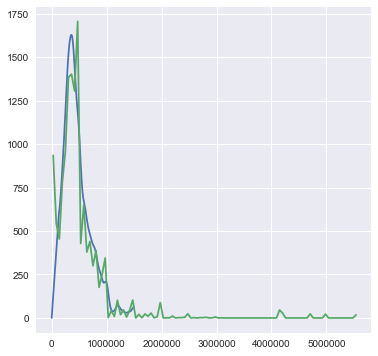

In [17]:
# And, get back to the counts, but now on the KDE

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(s,d * sum(hist*bin_width))

ax.plot(bin_middles, hist)

In [18]:
t[['VALUEH','HHINCOME']].describe()

,VALUEH,HHINCOME
count,1.357900e+04,1.357900e+04
mean,5.026172e+05,8.569048e+04
std,5.430300e+05,8.603261e+04
min,1.300000e+02,0.000000e+00
25%,2.500000e+05,3.300000e+04
50%,4.000000e+05,6.240000e+04
75%,6.000000e+05,1.076250e+05
max,5.567000e+06,1.095000e+06


2866.3507109


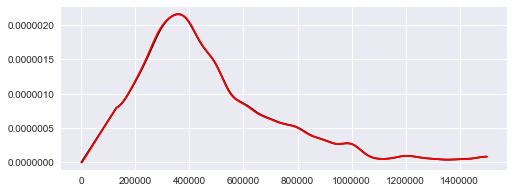

In [19]:
def plot_compare_curves(p25, p50, p75):
    fig = plt.figure(figsize = (8,3))
    ax = fig.add_subplot(111)

    sp, dp = interpolate_curve(s, d, p25, p50, p75)

    ax.plot(pd.Series(s), d, color='black');
    ax.plot(pd.Series(sp), dp, color='red');

# Re-input the quantiles for the KDE
# Curves should be co-incident
plot_compare_curves(2.800000e+05,4.060000e+05,5.800000e+05)


16597.535545


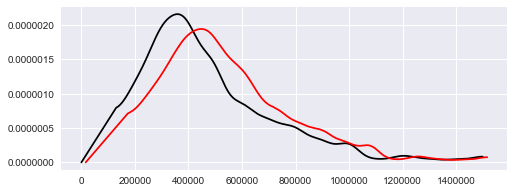

In [20]:
# Values for SD County home values
plot_compare_curves(349100.0,485900.0,703200.0)


16597.535545


count    1.000000e+04
mean     5.223612e+05
std      2.525977e+05
min      2.189194e+04
25%      3.508070e+05
50%      4.842791e+05
75%      6.563583e+05
max      1.515253e+06
dtype: float64

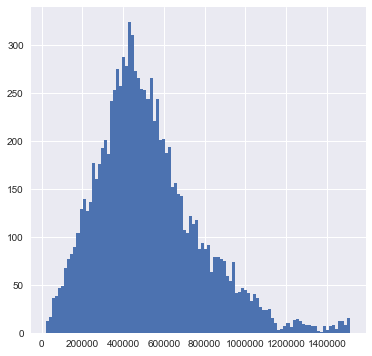

In [21]:
sp, dp = interpolate_curve(s, d, 349100.0,485900.0,703200.0)
v = syn_dist(sp, dp, 10000)

plt.hist(v, bins=100);  
pd.Series(v).describe()

In [22]:
incv.VALUEH.count()

13579